## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, learning_curve

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [65]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97374 entries, 0 to 97373
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               97374 non-null  object 
 1   continent                              92795 non-null  object 
 2   location                               97374 non-null  object 
 3   date                                   97374 non-null  object 
 4   total_cases                            93971 non-null  float64
 5   new_cases                              93968 non-null  float64
 6   new_cases_smoothed                     92958 non-null  float64
 7   total_deaths                           83909 non-null  float64
 8   new_deaths                             84065 non-null  float64
 9   new_deaths_smoothed                    92958 non-null  float64
 10  total_cases_per_million                93470 non-null  float64
 11  ne

In [67]:
world_continents = ['World', 'Europe', 'South America', 'North America', 'Asia', 'European Union', 'Africa']

In [68]:
search_country_df = df[df.date == '2021-06-20'].sort_values(by='total_deaths', ascending=False)
# Buscamos los datos de una fecha específica para identificar los paises

In [69]:
search_country_df[~search_country_df['location'].isin(world_continents)].head(20)
# Eliminamos los continentes de la lista para quedarnos con los paises

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
92798,USA,North America,United States,2021-06-20,33541887.0,3892.0,11412.000,601824.0,83.0,281.857,...,1.2,151.089,10.79,19.1,24.6,NaN,2.770,78.86,0.926,NaN
12863,BRA,South America,Brazil,2021-06-20,17927928.0,44178.0,73594.571,501825.0,1025.0,2060.571,...,3.4,177.961,8.11,10.1,17.9,NaN,2.200,75.88,0.765,NaN
40772,IND,Asia,India,2021-06-20,29935221.0,53449.0,60687.286,388135.0,1427.0,1975.714,...,21.2,282.280,10.39,1.9,20.6,59.550,0.530,69.66,0.645,NaN
57185,MEX,North America,Mexico,2021-06-20,2477283.0,5542.0,3301.000,231187.0,228.0,148.143,...,2.5,152.783,13.06,6.9,21.4,87.847,1.380,75.05,0.779,NaN
69818,PER,South America,Peru,2021-06-20,2026729.0,3550.0,3300.571,190202.0,269.0,213.429,...,3.5,85.755,5.95,4.8,NaN,NaN,1.600,76.74,0.777,NaN
92281,GBR,Europe,United Kingdom,2021-06-20,4646068.0,9077.0,9184.143,128240.0,6.0,10.286,...,0.2,122.137,4.28,20.0,24.7,NaN,2.540,81.32,0.932,NaN
44351,ITA,Europe,Italy,2021-06-20,4252976.0,881.0,1157.714,127270.0,17.0,38.286,...,2.0,113.151,4.78,19.8,27.8,NaN,3.180,83.51,0.892,NaN
72763,RUS,Europe,Russia,2021-06-20,5255214.0,17367.0,15245.000,127206.0,445.0,413.143,...,0.1,431.297,6.18,23.4,58.3,NaN,8.050,72.58,0.824,NaN
32055,FRA,Europe,France,2021-06-20,5819088.0,1816.0,2396.286,110900.0,14.0,49.571,...,NaN,86.060,4.77,30.1,35.6,NaN,5.980,82.66,0.901,NaN
19284,COL,South America,Colombia,2021-06-20,3945166.0,27818.0,27420.286,99934.0,599.0,593.714,...,4.5,124.240,7.44,4.7,13.5,65.386,1.710,77.29,0.767,NaN


Nos quedamos con Brasil

In [70]:
df = df[df.location == 'Brazil']
df = df.set_index('date')
df = df[['new_cases', 'new_deaths', 'population', 'total_deaths', 'total_cases']]

<AxesSubplot:xlabel='date'>

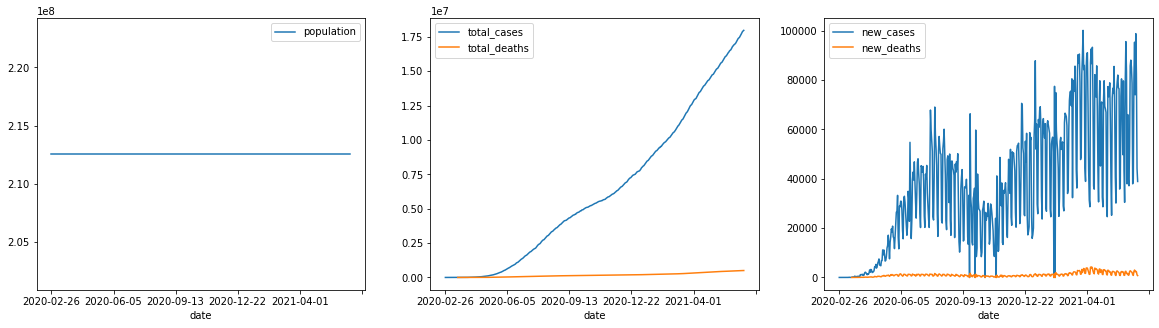

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
df['population'].plot(ax=ax[0], legend=True)
df[['total_cases', 'total_deaths']].plot(ax=ax[1], legend=True)
df[['new_cases', 'new_deaths']].plot(ax=ax[2], legend=True)

In [72]:
df = df.drop('population', axis=1)

Contamos los valores nulos

In [73]:
df.isna().mean()

new_cases       0.000000
new_deaths      0.041494
total_deaths    0.041494
total_cases     0.000000
dtype: float64

In [74]:
df = df.dropna()

In [75]:
df.head()

,new_cases,new_deaths,total_deaths,total_cases
date,,,,
2020-03-17,121.0,1.0,1.0,321.0
2020-03-18,51.0,2.0,3.0,372.0
2020-03-19,249.0,3.0,6.0,621.0
2020-03-20,172.0,5.0,11.0,793.0
2020-03-21,228.0,4.0,15.0,1021.0


In [76]:
df.shape[0] * 0.8

369.6

In [77]:
X = df[['new_deaths', 'total_deaths', 'total_cases']].to_numpy()
target = df['new_cases'].to_numpy()

Entrenamiento

In [78]:
seed = 42

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=seed)

In [80]:
k_fold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=seed)

In [81]:
# Curva de aprendizaje
def plot_learning_curve(model, X, y):
    # Esta curva representa la curva de entrenamiento y de validación cuando se entrena el modelo con una parte de los datos
    # cada vez más grande
    fig, ax = plt.subplots()    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    ax.plot(train_sizes,np.mean(train_scores,axis=1), label='Train curve')
    ax.plot(train_sizes,np.mean(test_scores,axis=1), label='Validation curve')
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Número de datos')
    ax.set_ylabel('Score')
    ax.legend()
    return ax
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    plt.plot(train_sizes,np.mean(train_scores,axis=1), label='Train curve')
    plt.plot(train_sizes,np.mean(test_scores,axis=1), label='Validation curve')
    plt.legend()

In [82]:
# Entrenamiento cruzado
def training_cross_validation(model, X, y, k_fold):
    # Esta curva representa la curva de entrenamiento y de validación realizando un cross validation para obtener los índices
    fig, ax = plt.subplots()
    val_score = []
    train_score = []
    tamano = []
    for i, (train, val) in enumerate(k_fold.split(X)):
        model.fit(X[train], y[train])
        score_val = model.score(X[val], y[val])
        val_score.append(score_val)
        score_train = model.score(X[train], y[train])
        train_score.append(score_train)
        tamano.append(i)
    
    ax.plot(tamano, train_score, label='Training')
    ax.plot(tamano, val_score, label='Validation')
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Número de iteraciones')
    ax.set_ylabel('Score')
    ax.legend()
    
    return ax

LinearRegression

<AxesSubplot:title={'center':'LinearRegression'}, xlabel='Número de iteraciones', ylabel='Score'>

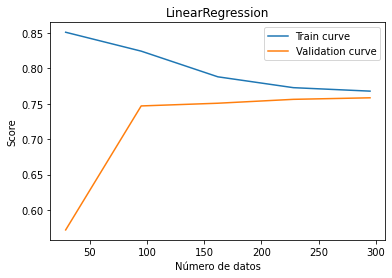

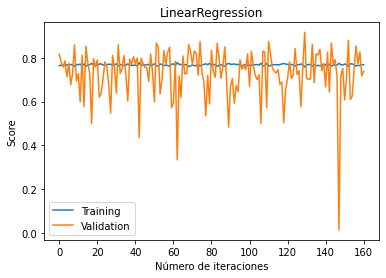

In [83]:
model = LinearRegression()
plot_learning_curve(model, X_train, y_train)
training_cross_validation(model, X_train, y_train, k_fold)

<AxesSubplot:title={'center':'LinearRegression'}, xlabel='Número de iteraciones', ylabel='Score'>

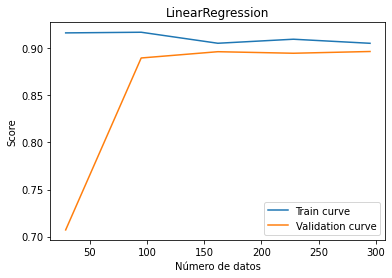

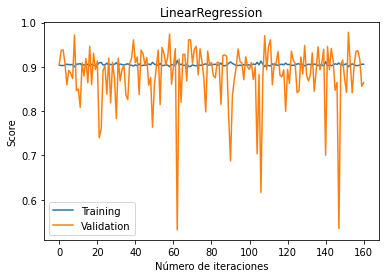

In [84]:
model = LinearRegression()
poly_transform = PolynomialFeatures(degree=2)
X_poly_train = poly_transform.fit_transform(X_train)

plot_learning_curve(model, X_poly_train, y_train)
training_cross_validation(model, X_poly_train, y_train, k_fold)

<AxesSubplot:title={'center':'SVR'}, xlabel='Número de iteraciones', ylabel='Score'>

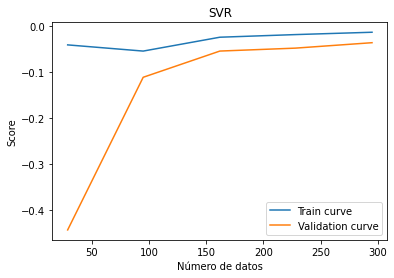

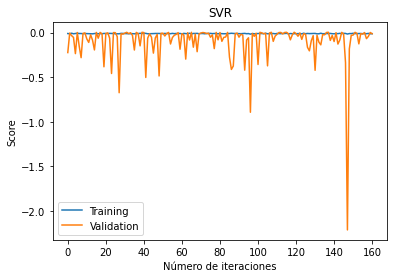

In [85]:
model = SVR()
plot_learning_curve(model, X_train, y_train)
training_cross_validation(model, X_train, y_train, k_fold)

<AxesSubplot:title={'center':'DecisionTreeRegressor'}, xlabel='Número de iteraciones', ylabel='Score'>

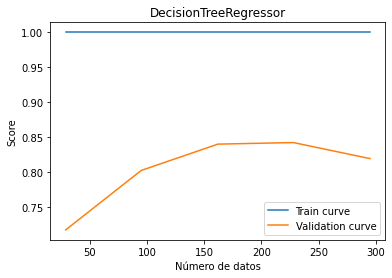

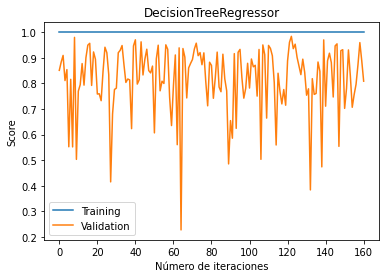

In [86]:
model = DecisionTreeRegressor()
plot_learning_curve(model, X_train, y_train)
training_cross_validation(model, X_train, y_train, k_fold)